In [1]:
import time
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import calibration_curve
from sklearn.svm import SVC
from sklearn.metrics import brier_score_loss
from itertools import combinations


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Cleaning of the dataset

I will use two datasets for my models: the first one is "diabete" and is the one I'm going to train the model on. The second one will be "data_test" and will be use only to validate the model. It is a different set of datas than "diabete".

In [2]:
diabete=pd.read_csv("D:/fanny/Documents/cours/ITBA/analisis predictivo/diabetes_binary_5050split_health_indicators_BRFSS2015.csv")
data_test=pd.read_csv("D:/fanny/Documents/cours/ITBA/analisis predictivo/diabetes_binary_health_indicators_BRFSS2015.csv")
diabete

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,1.0,0.0,1.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,0.0,0.0,6.0,4.0,1.0
70688,1.0,0.0,1.0,1.0,29.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,2.0,0.0,0.0,1.0,1.0,10.0,3.0,6.0
70689,1.0,1.0,1.0,1.0,25.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,5.0,15.0,0.0,1.0,0.0,13.0,6.0,4.0
70690,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0


We first look at the repartition of sick and non-sick people in our dataset. 1 is for the people who have diabete and 0 for the people who don't.

The first one is the training data set "diabete". It is balanced.

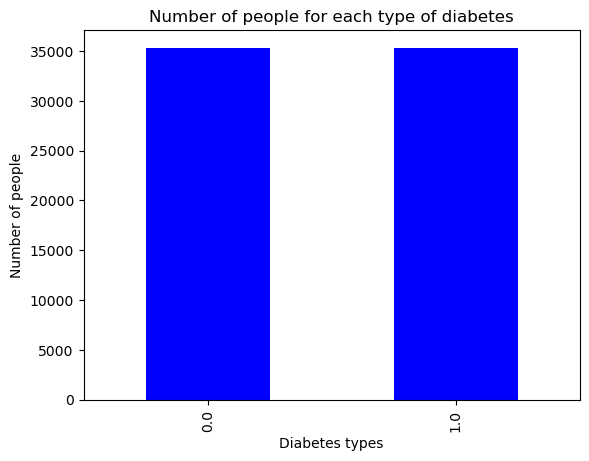

In [3]:
# Calculate the number of people in each type of diabetes and create a barplot
freq_table = diabete['Diabetes_binary'].value_counts()

freq_table.plot(kind='bar', color='blue')
plt.xlabel('Diabetes types')
plt.ylabel('Number of people')
plt.title('Number of people for each type of diabetes')
plt.show()

The second one is the test data_set. It is unbalanced.

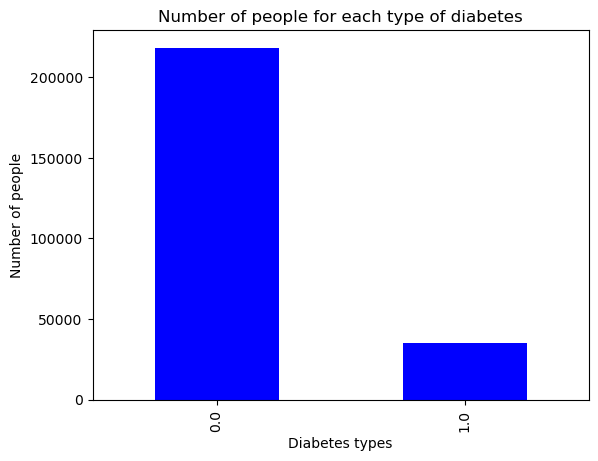

In [4]:
# Calculate the number of people in each type of diabetes
freq_table = data_test['Diabetes_binary'].value_counts()

# Create a barplot
freq_table.plot(kind='bar', color='blue')
plt.xlabel('Diabetes types')
plt.ylabel('Number of people')
plt.title('Number of people for each type of diabetes')
plt.show()

We change the name from the column Diabetes_binary to diabete, and we turn the type to 'category'.

In [5]:
# Create a new column 'diabete' and assign the values from 'Diabetes_binary'
diabete['diabete'] = diabete['Diabetes_binary']
data_test['diabete'] = data_test['Diabetes_binary']

# Remove the 'Diabetes_binary' column from the DataFrame
diabete = diabete.drop(columns=['Diabetes_binary'])
data_test = data_test.drop(columns=['Diabetes_binary'])



In [6]:
diabete['diabete'].dtype

dtype('float64')

In [7]:
diabete['diabete'] = diabete['diabete'].astype('category')

## Missing values

In [8]:
#Count the missing values in each variable
diabete.isna().sum()

HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
diabete                 0
dtype: int64

There are none, the dataset was already cleaned.

# Exploratory analysis

## Categorical variables

I first took a look at the repartition of categorical variables.

The aim is to compare for each categorical variable the percentage of sick people and the percentage of healthy people.

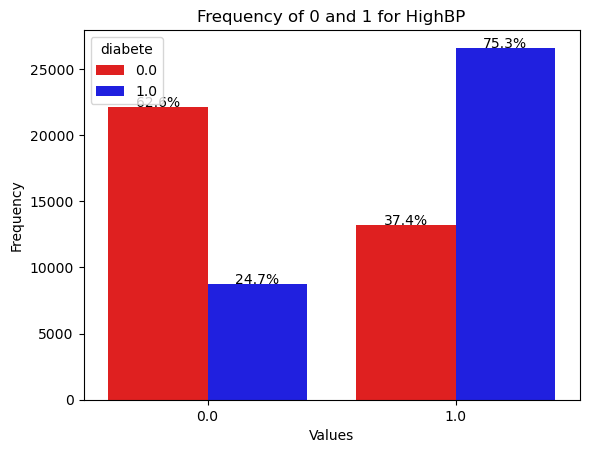

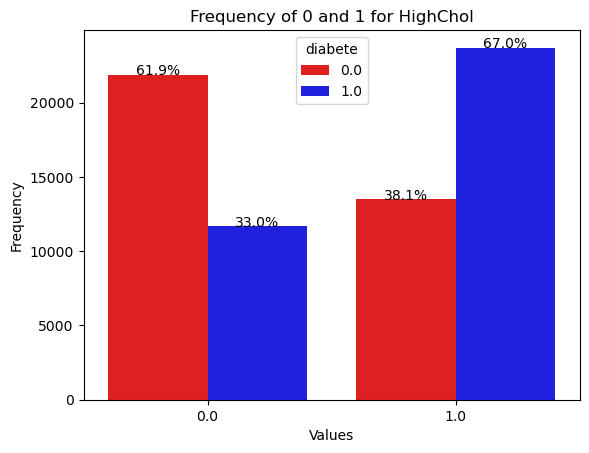

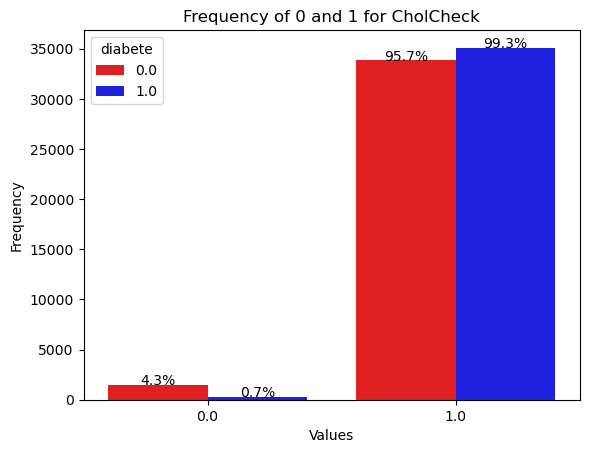

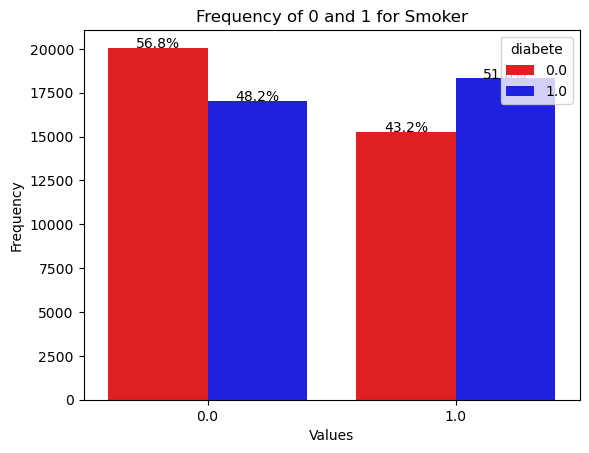

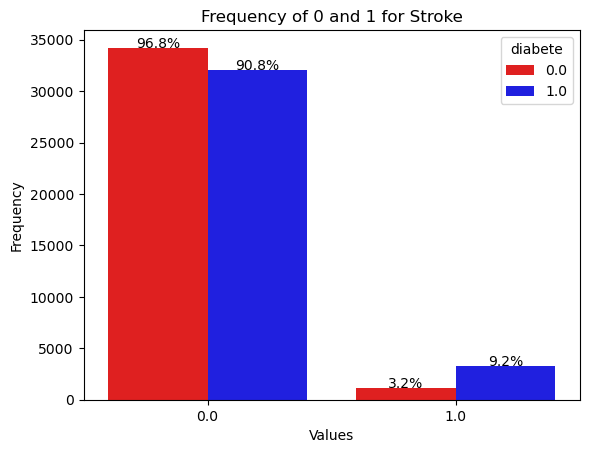

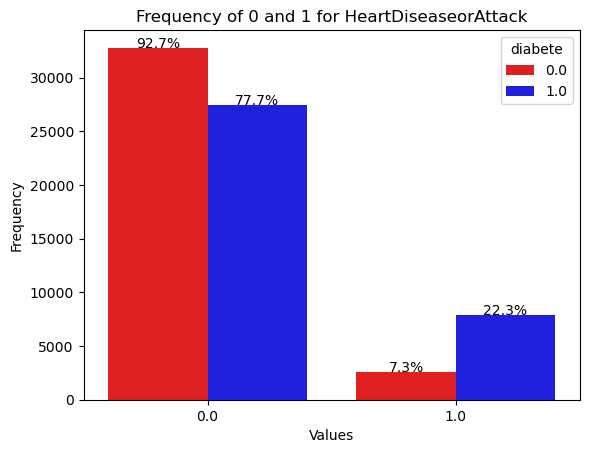

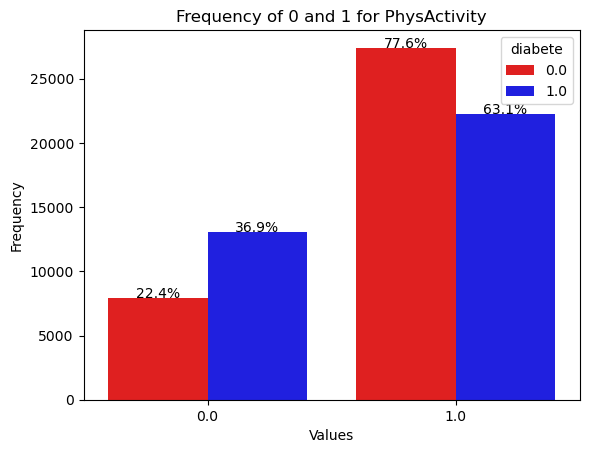

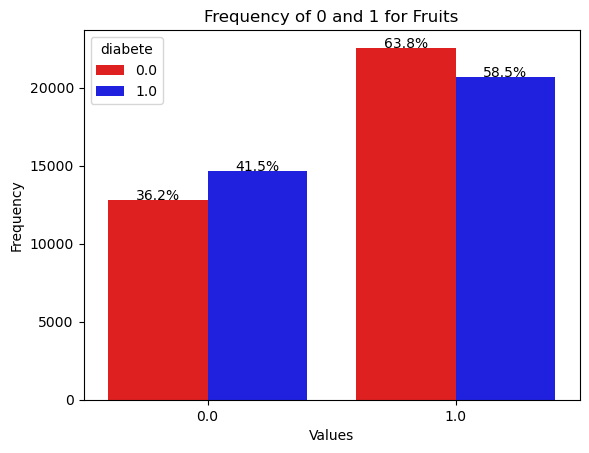

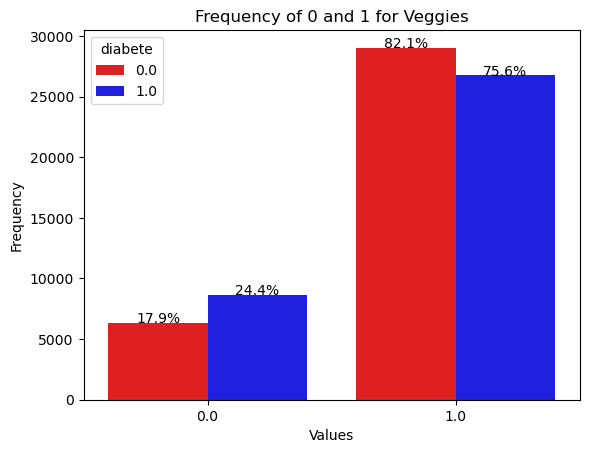

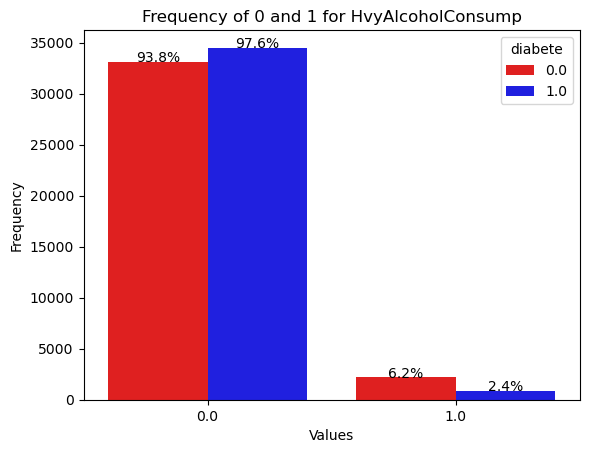

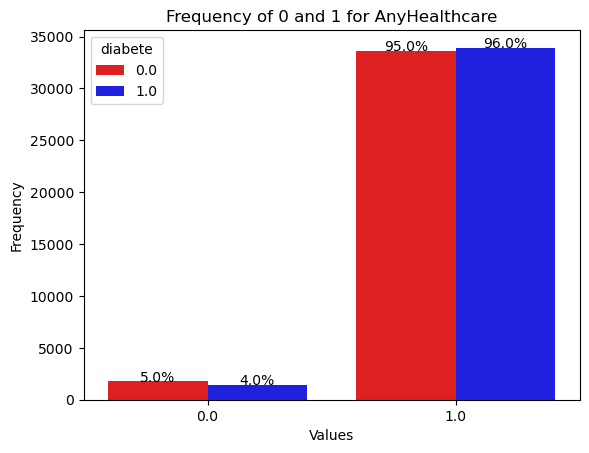

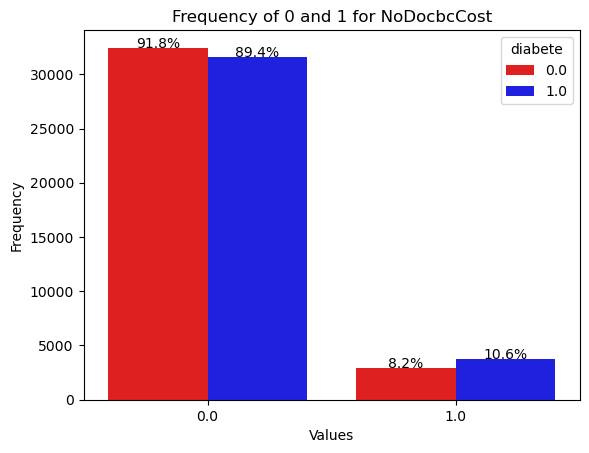

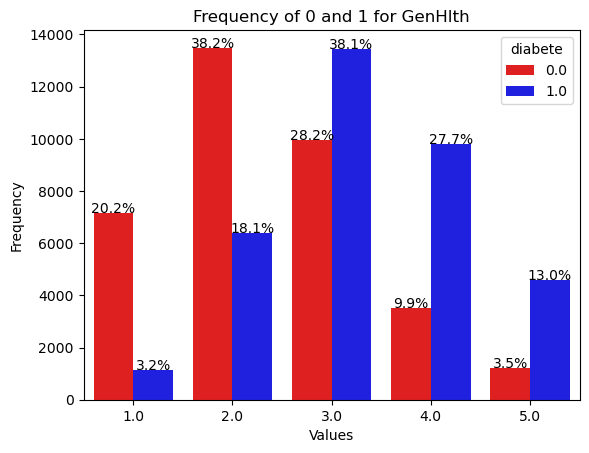

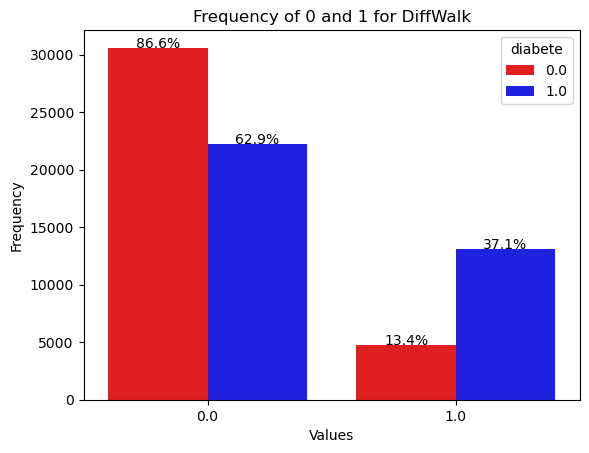

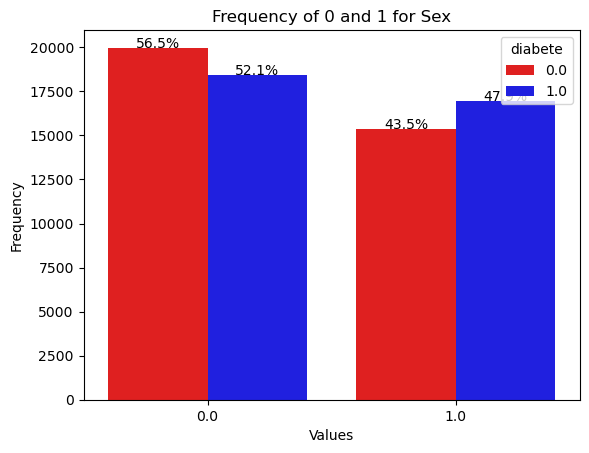

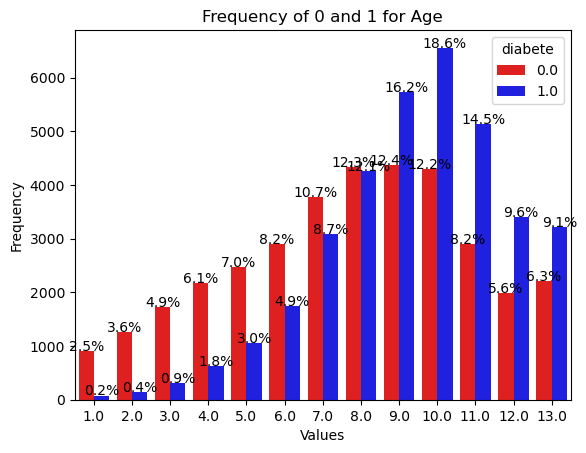

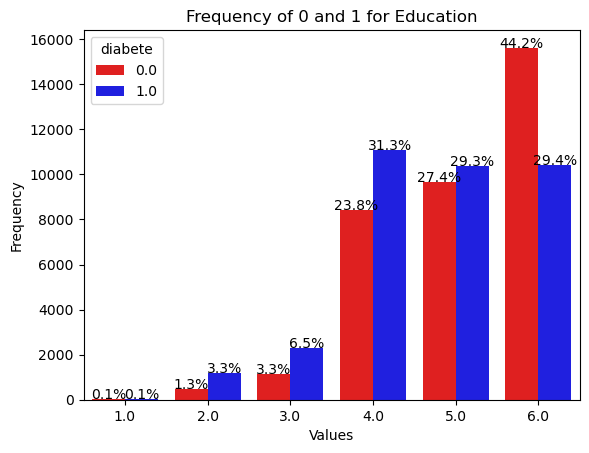

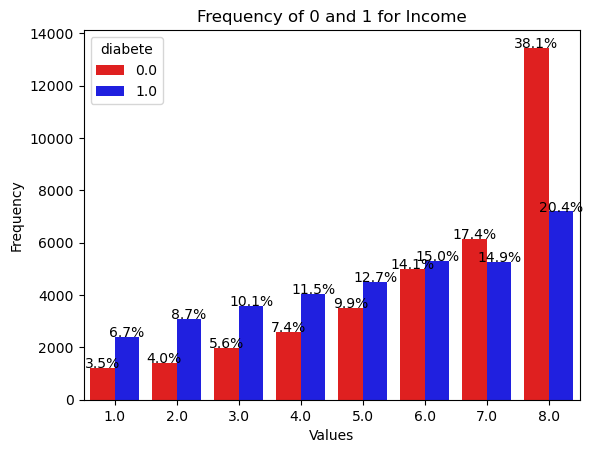

In [9]:
# Create a DataFrame with categorical variables for people with and without diabetes
cat = diabete.drop(columns=['BMI', 'MentHlth', 'PhysHlth'])

# Create barplots for each variable
for i in range(cat.shape[1] - 1):  # -1 to avoid the 'diabete' column
    column_name = cat.columns[i]

    p = sns.countplot(x=column_name, hue='diabete', data=cat, dodge=True, palette={1: 'blue', 0: 'red'})
    plt.title(f'Frequency of 0 and 1 for {column_name}')
    plt.xlabel('Values')
    plt.ylabel('Frequency')

    # Display percentages on top of the bars
    total = len(cat)
    for patch in p.patches:
        height = patch.get_height()*2
        p.text(patch.get_x() + patch.get_width() / 2, height/2 + 5, f'{height/total:.1%}', ha='center')

    plt.show()

If we take the example of High Blood Pressure (HighBP), we can see that 2/3 of people who don't have diabete have low blood pressure, whereas 3/4 of people who have the disease have high blood pressure. We can guess that a person is more likely to have high blood pressure when he or she has diabete.

## Numerical variables

I now look at the numerical variables. I ploted the histogram to see the repartition.

<Axes: xlabel='BMI', ylabel='Count'>

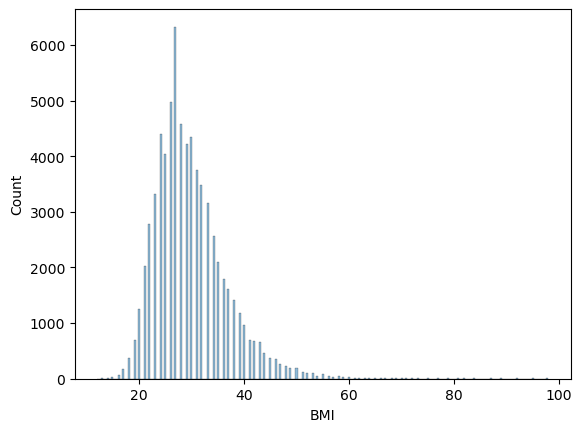

In [10]:
sns.histplot(data=diabete, x='BMI', alpha=0.5)

<Axes: >

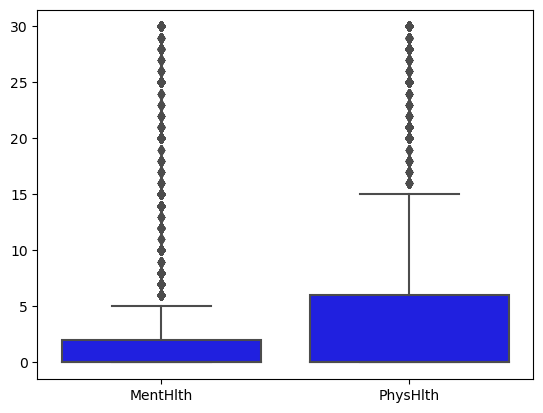

In [11]:
sns.boxplot(data=diabete[['MentHlth','PhysHlth']], color='blue')

## Correlation

### Categorical variables

We do a correlation matrix with Cramer's V.

In [12]:
def cramer_v(df, x, y):
    confusion_matrix = pd.crosstab(df[x], df[y])
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


In [13]:
def cramer_cors(df, col_names):
    combinations_list = list(combinations(col_names, 2))
    
    # Ajoute les paires de variables où Var1 est égale à Var2
    for col in col_names:
        combinations_list.append((col, col))
    
    df_cor = pd.DataFrame(combinations_list, columns=["Var1", "Var2"])
    df_cor["cramer_v"] = df_cor.apply(lambda row: cramer_v(df, row["Var1"], row["Var2"]), axis=1)
    df_cor = df_cor.sort_values(by="cramer_v", ascending=False)
    return df_cor


In [14]:
variable_names = cat.columns.tolist()

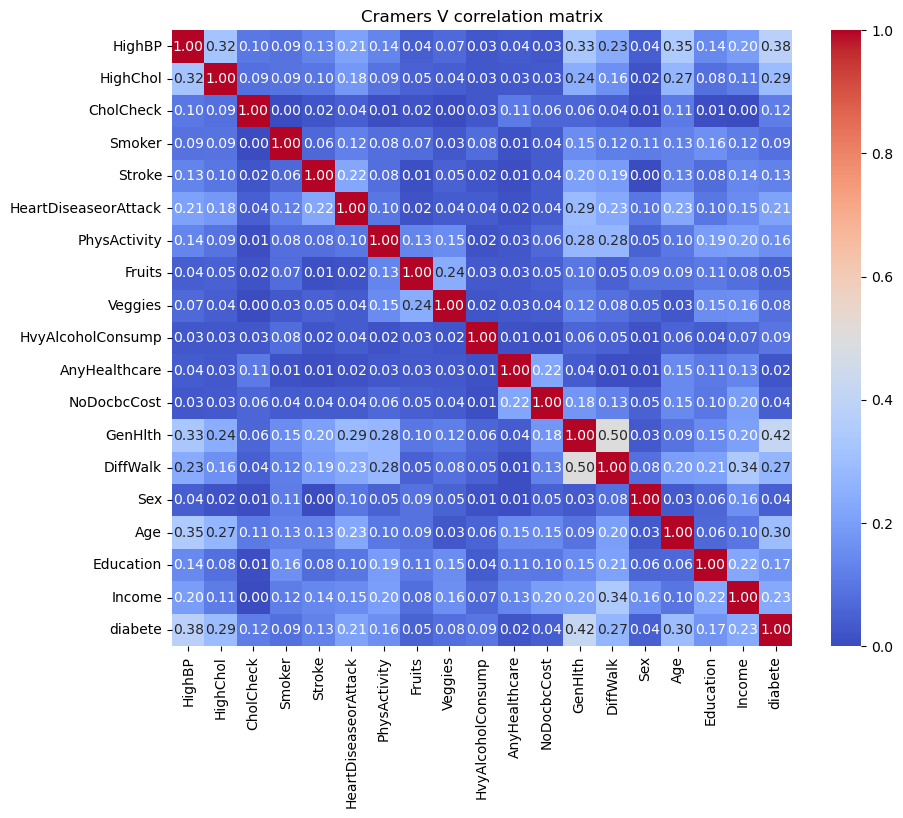

In [15]:
df_correlation = cramer_cors(cat, variable_names)


num_cols = len(variable_names)
correlation_matrix = np.zeros((num_cols, num_cols))

for index, row in df_correlation.iterrows():
    var1_index = variable_names.index(row['Var1'])
    var2_index = variable_names.index(row['Var2'])
    correlation_matrix[var1_index, var2_index] = row['cramer_v']
    correlation_matrix[var2_index, var1_index] = row['cramer_v']

# Print the matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=cat.columns, yticklabels=cat.columns)
plt.title('Cramers V correlation matrix')
plt.show()

DiffWalk and GenHlth seems to be correlated. We calculate the VIF to knowif there is a colinearity between the 2 variables, in order to see if we can remove one of them.

In [16]:
col = cat[['GenHlth', 'DiffWalk']]
col = sm.add_constant(col)  # Ajouter une colonne de constante pour l'intercept
vif_data = pd.DataFrame()
vif_data["Variable"] = col.columns
vif_data["VIF"] = [variance_inflation_factor(col.values, i) for i in range(col.shape[1])]

print(vif_data)

   Variable       VIF
0     const  8.009282
1   GenHlth  1.293970
2  DiffWalk  1.293970


VIF < 5 so we keep them both.

### Numerical variables

               BMI  MentHlth  PhysHlth
BMI       1.000000  0.086932  0.166514
MentHlth  0.086932  1.000000  0.345337
PhysHlth  0.166514  0.345337  1.000000


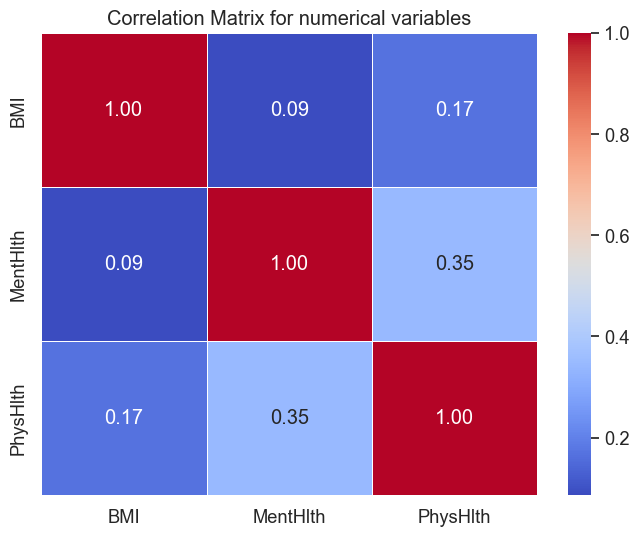

In [17]:
a = diabete[["BMI", "MentHlth", "PhysHlth"]].copy()

# Calcul de la matrice de corrélation de Spearman
cor_mat_spearman = a.corr(method='spearman')

# Impression de la matrice de corrélation
print(cor_mat_spearman)

# Création d'un graphique de la matrice de corrélation
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cor_mat_spearman, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix for numerical variables")
plt.show()

The variables aren't correlated.

# Logistic regression

The first model I chose to do is a logistic regression. It is a basic model that will help for comparing the others.

Since I want probabilities of having diabete and not only predicting if a person have diabete or not, I won't calculate the accuracy. Also, the dataset I will use to validate the predictions is not balanced so the accuracy is not the best method to evaluate the model.

Instead, I will use the ROC score and the Brier score to determine which model is the best.

First, I train the model on the training dataset "diabete".

In [18]:
# Split the datas between the response variable y and the rest X
X = diabete.drop(columns=['diabete'])
y = diabete['diabete']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Initialize and fit logistic regression model
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

# Predict probabilities on the test set
y_pred_proba = logreg_model.predict_proba(X_test)[:, 1]  # Probabilities for positive class

# Evaluate the model
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC Score: {roc_auc:.4f}')

ROC-AUC Score: 0.8175


C:\Users\fanny\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


I do the calibration curve to see if the preditions are close to the true values.

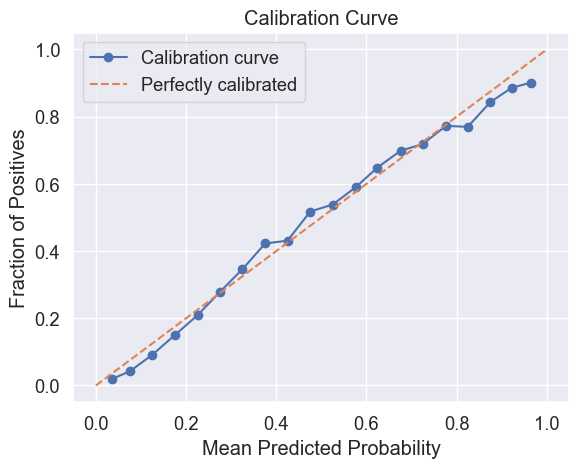

In [19]:
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=20)

# Plot the calibration curve
plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

Now I use this model on the validation dataset.

In [20]:
X_data_test = data_test.drop(columns=['diabete'])
y_data_test = data_test['diabete']

y_pred_proba_new = logreg_model.predict_proba(X_data_test)[:, 1]

roc_auc = roc_auc_score(y_data_test, y_pred_proba_new)
print(f'ROC-AUC Score : {roc_auc:.4f}')

ROC-AUC Score : 0.8153


In [21]:
# Calculate Brier Score for training dataset
brier_score = brier_score_loss(y_test, y_pred_proba)

print(f'Brier Score training: {brier_score:.4f}')

# Calculate Brier Score for the validation dataset
brier_score = brier_score_loss(y_data_test, y_pred_proba_new)

print(f'Brier Score validation: {brier_score:.4f}')

Brier Score training: 0.1736
Brier Score test: 0.1827


# Final model : Random Forest

My final model is Random Forest. I chose it after testing also xgboost and svm, and this one was the best in terms of score.

To choose the hyperparameters, I used GridSearch. I tested different parameters and change them after testing to see which one was the best: for example, for n_estimators, I started with [100, 200, 300] and since 200 was the best, I did [150,200,250], etc... until finding the best one.

In [108]:
temps_debut = time.time()

# Split the datas between the response variable y and the rest X
X = diabete.drop(columns=['diabete'])
y = diabete['diabete']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize and fit the model RandomForestClassifier
rf_model = RandomForestClassifier()

# Define the grid of hyperparameters
param_grid = {
    'n_estimators': [210],
    'max_depth': [12],
    'min_samples_split': [3],
    'min_samples_leaf': [3]
}

# Use the grid to find the best hyperparameters
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)


print("Best parameters :", grid_search.best_params_)

# Use the model with the best hyperparameters
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

# Predict probabilities on the test set
y_pred_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]

# Evalueate the model
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f'ROC-AUC Score: {roc_auc_rf:.4f}')
temps_fin = time.time()
temps_execution = temps_fin - temps_debut

print("Execution time is", temps_execution, "seconds.")

Best parameters : {'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 210}
ROC-AUC Score: 0.8288
Execution time is 62.83858942985535 seconds.


I plot the calibration curve.

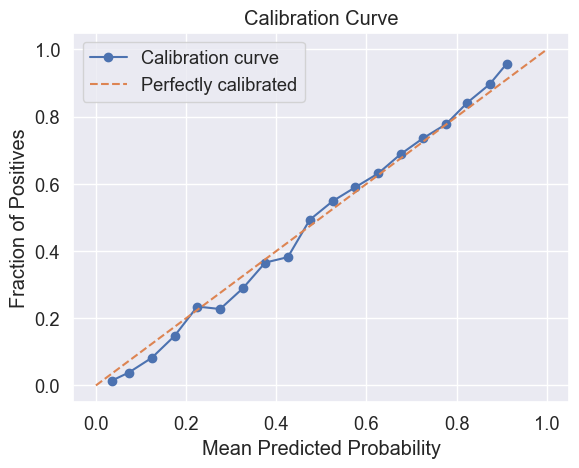

In [109]:
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba_rf, n_bins=20)

# Plot the calibration curve
plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

I also did the ROC curve.

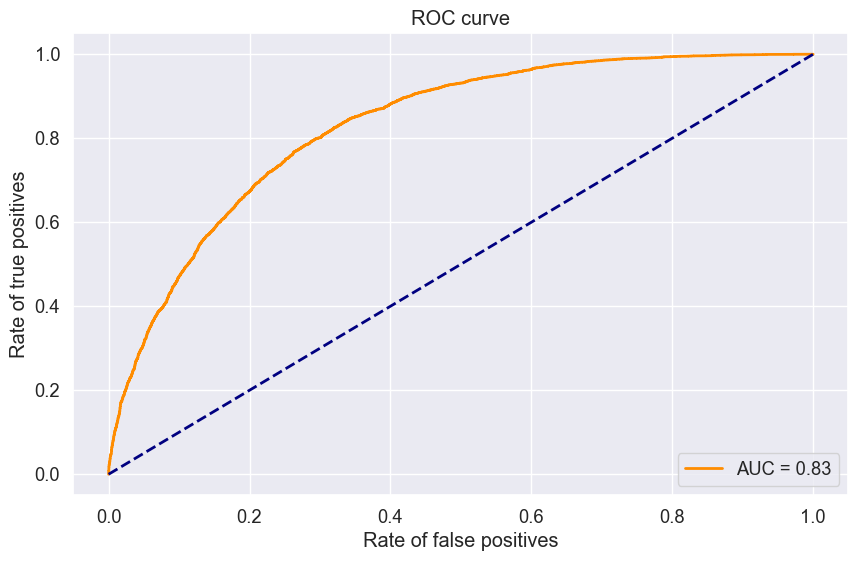

In [110]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_rf)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Rate of false positives')
plt.ylabel('Rate of true positives')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

### Validation dataset

Now I apply this model with the validation dataset.

In [112]:
X_data_test = data_test.drop(columns=['diabete'])
y_data_test = data_test['diabete']

y_pred_proba_rf_new = best_rf_model.predict_proba(X_data_test)[:, 1]

roc_auc_rf = roc_auc_score(y_data_test, y_pred_proba_rf_new)
print(f'ROC-AUC Score: {roc_auc_rf:.4f}')

ROC-AUC Score: 0.8463


In [111]:
# Calculate Brier Score for training data
brier_score = brier_score_loss(y_test, y_pred_proba_rf)

print(f'Brier Score training: {brier_score:.4f}')

# Calculate Brier Score for validation data
brier_score = brier_score_loss(y_data_test, y_pred_proba_rf_new)

print(f'Brier Score validation: {brier_score:.4f}')

Brier Score: 0.1680


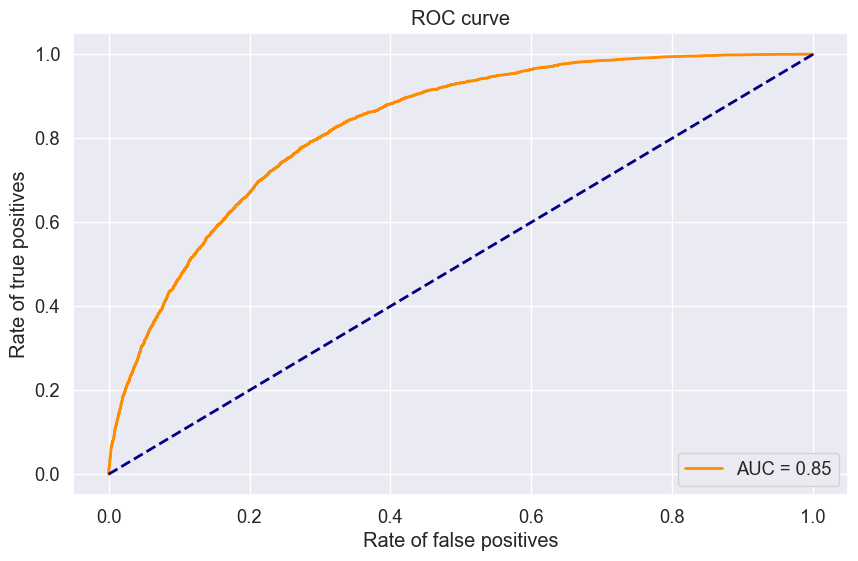

In [78]:
fpr_new, tpr_new, thresholds = roc_curve(y_data_test, y_pred_proba_rf_new)


roc_auc = auc(fpr_new, tpr_new)


plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Rate of false positives')
plt.ylabel('Rate of true positives')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

# Other models

I also did a model with xgboost and svm, but I didn't choose them so I didn't keep them in this code.